In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())

In [3]:
batch_size = 4

In [4]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
4


In [6]:
def imshow(img, title):
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [7]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

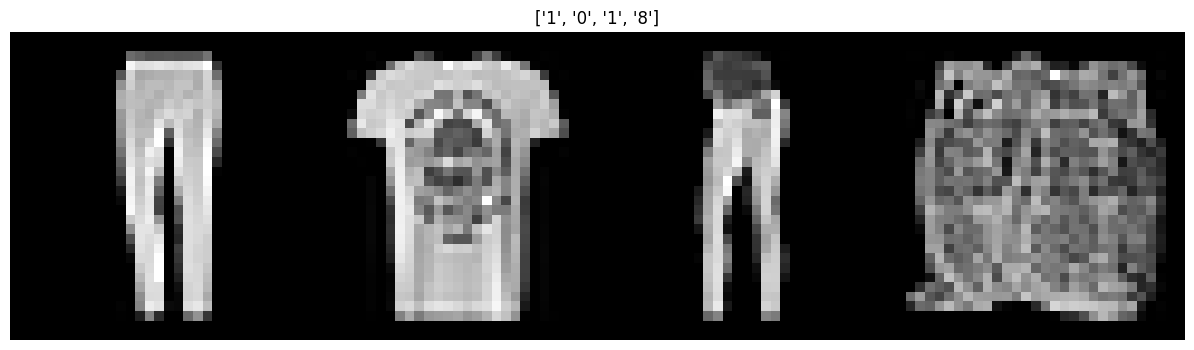

In [ ]:
images, labels = show_batch_images(trainloader)

In [9]:
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

In [10]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

In [11]:
model = NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
model_bn = BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [13]:
batch_size = 512

In [14]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer_bn = optim.SGD(model_bn.parameters(), lr=0.01)

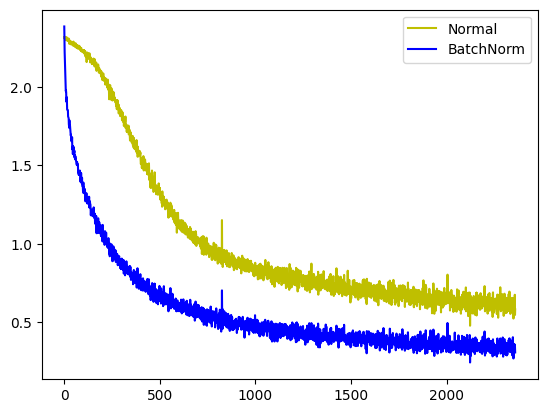

In [16]:
loss_arr = []
loss_bn_arr = []
max_epoch = 20

for epoch in range(max_epoch):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        optimizer_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        optimizer_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
plt.plot(loss_arr, 'y', label='Normal')
plt.plot(loss_bn_arr, 'b', label='BatchNorm')
plt.legend()
plt.show()

In [17]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros_like(x_train), torch.ones_like(x_train))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros_like(x_test), torch.ones_like(x_test))

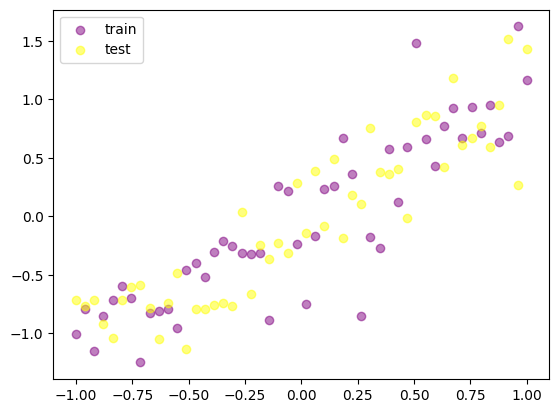

In [18]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c = 'purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c = 'yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [20]:
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [21]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

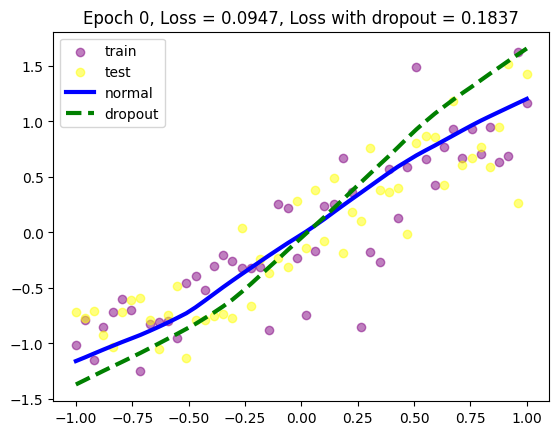

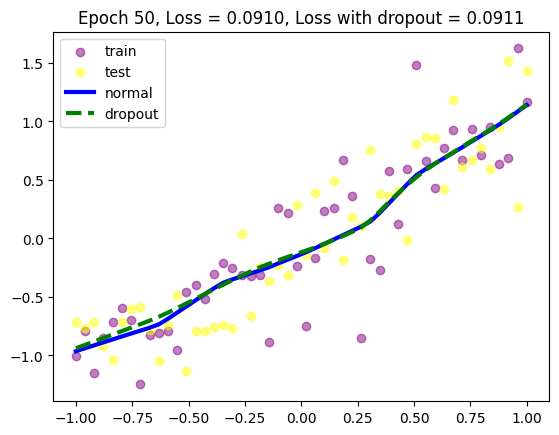

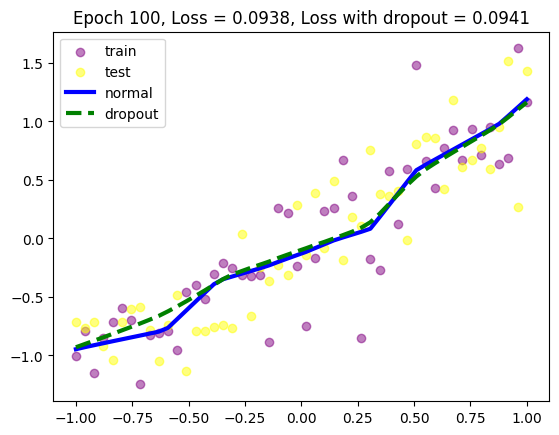

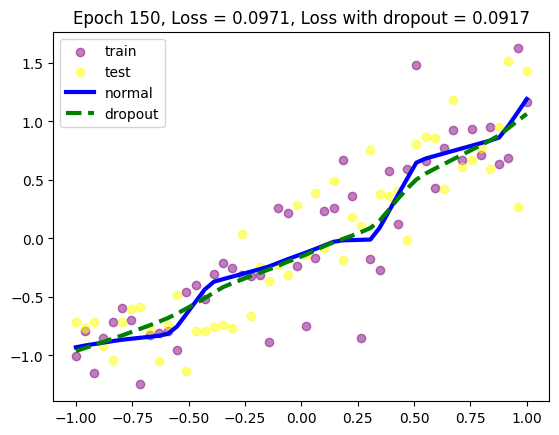

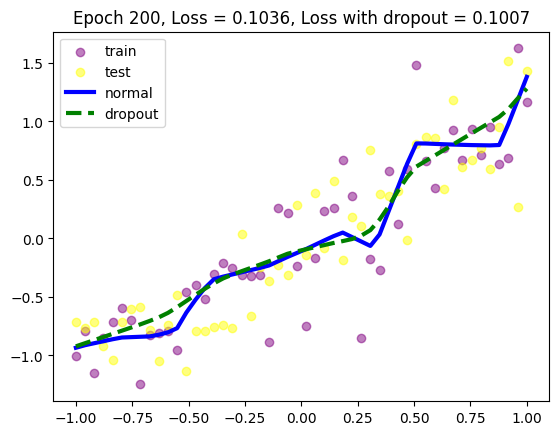

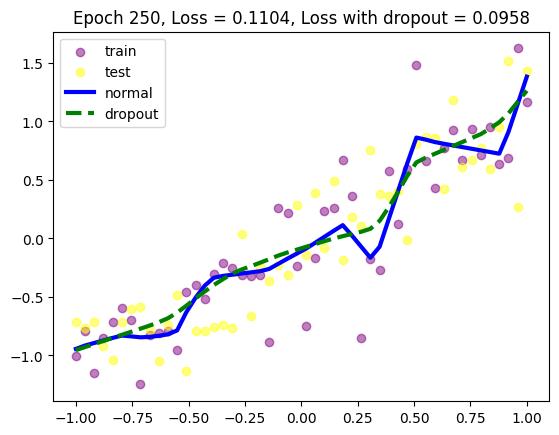

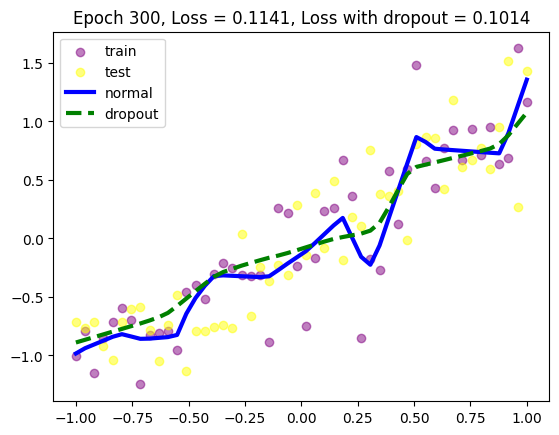

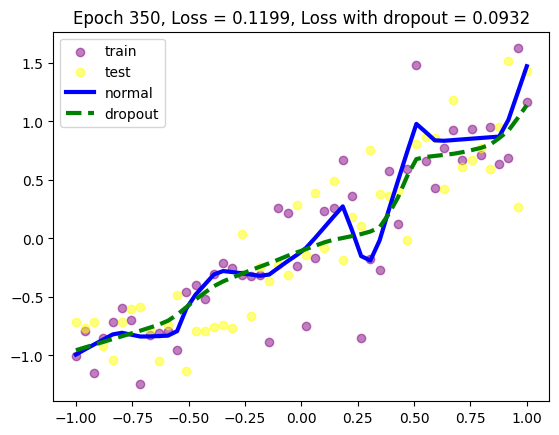

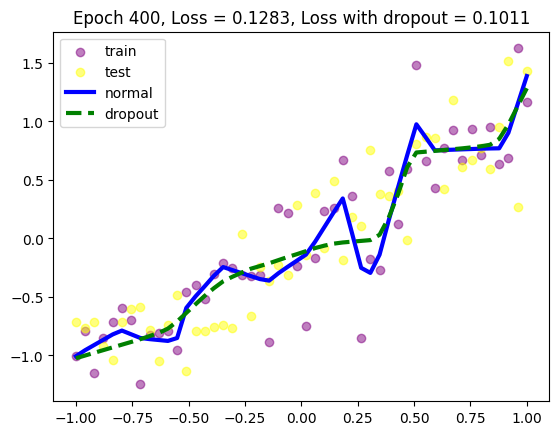

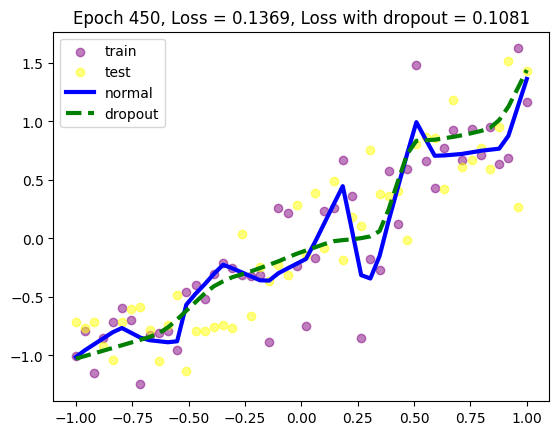

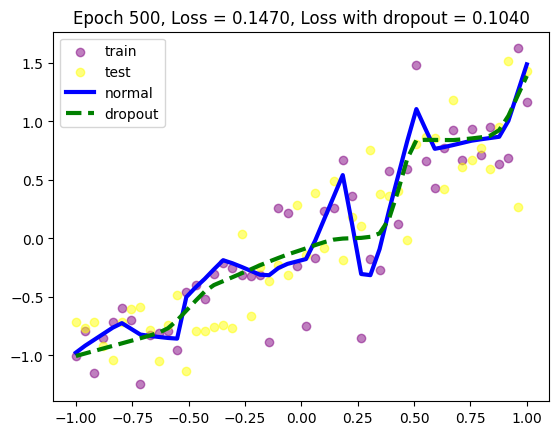

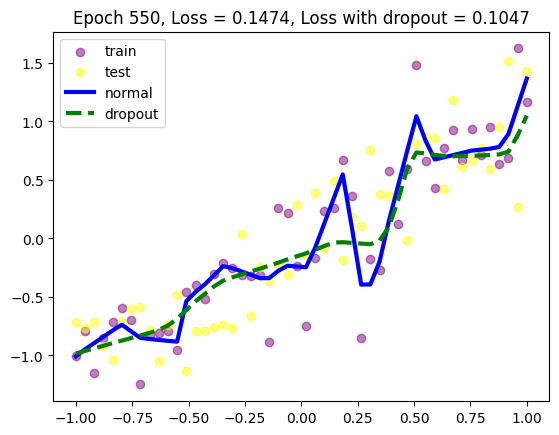

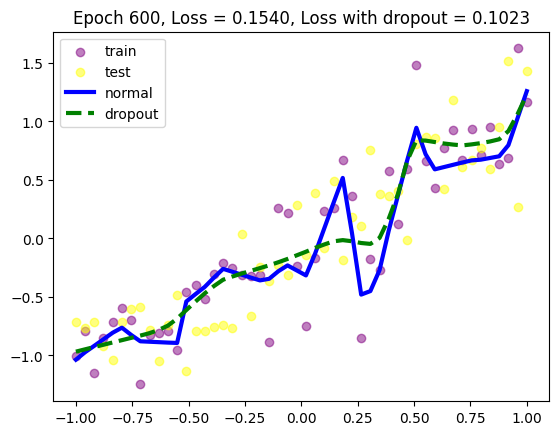

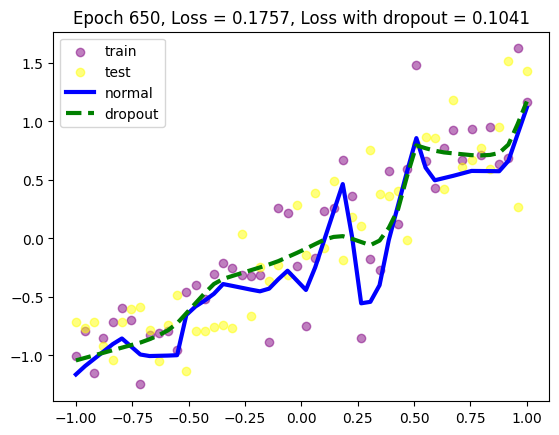

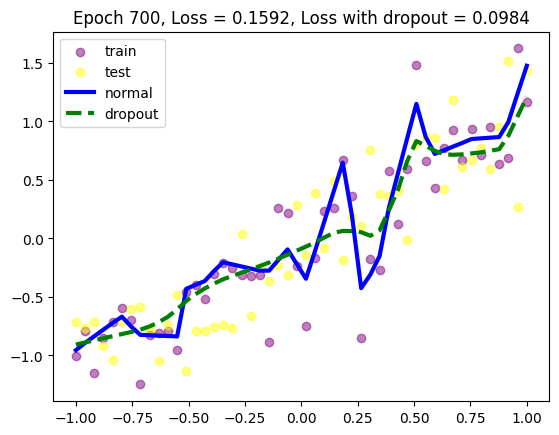

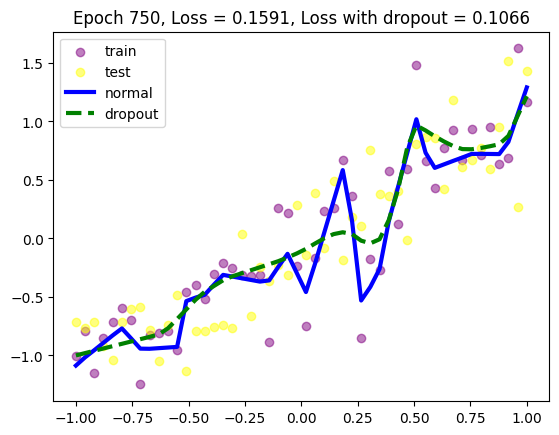

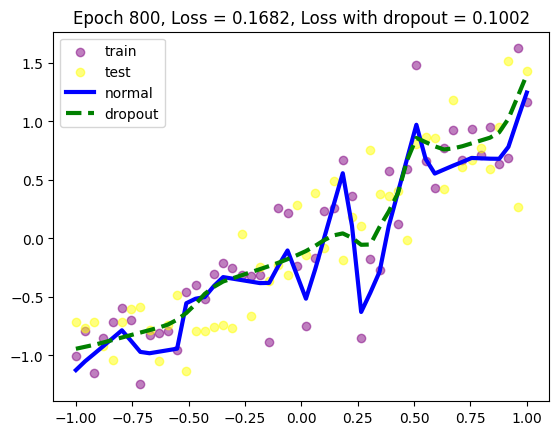

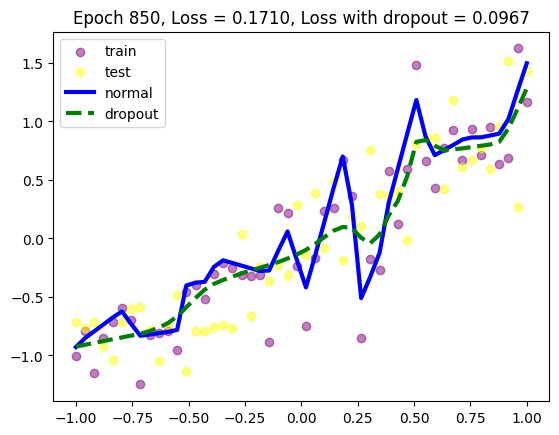

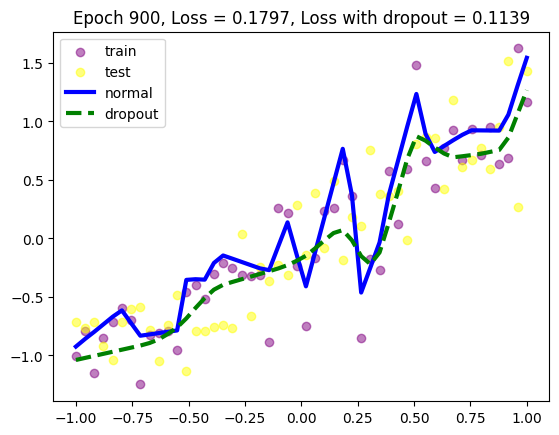

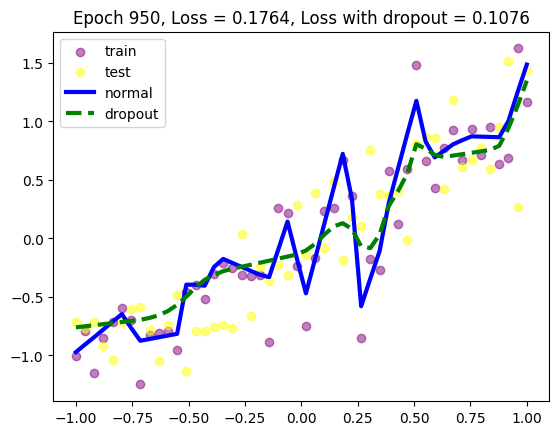

In [23]:
max_epoch = 1000
for epoch in range(max_epoch):
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    if epoch % 50 == 0:
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.detach().numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.detach().numpy(), 'g--', lw=3, label='dropout')
        
        plt.title(f'Epoch {epoch}, Loss = {test_loss:0.4f}, Loss with dropout = {test_loss_dropout:0.4f}')
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)